# Classificação de Risco: Insuficiência Cardíaca

O objetivo central deste estudo é aplicar um fluxo completo de Machine Learning para prever a mortalidade em pacientes com insuficiência cardíaca. O foco metodológico consiste na **avaliação comparativa de diferentes algoritmos de classificação** para identificar o modelo mais promissor para este problema.

### Fonte dos Dados
O conjunto de dados contém registros médicos de 299 pacientes e foi obtido através do Kaggle:
* **Dataset:** [Heart Failure Clinical Records Study](https://www.kaggle.com/datasets/guriya79/heart-failure-prediction-dataset)
* **Alvo (Target):** `DEATH_EVENT` (Se o paciente faleceu ou sobreviveu durante o período de acompanhamento).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../src')
from modeling.train import train_RandomForestClassifier_grid, train_LogisticRegression_grid, train_SVC_grid, train_GradientBoostingClassifier_grid, train_DecisionTreeClassifier_grid, train_MLPClassifier_grid, train_KNeighborsClassifier_grid
from plots import plot_model_performance, plot_grid_performance
from features import prepare_modeling_data_heart_failure
import shap

In [2]:
data = pd.read_csv("../data/raw/heart_failure_clinical_records_dataset.csv")
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [3]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [4]:
data.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

## Pré-processamento e Padronização dos Dados
Nesta etapa, isolamos as variáveis preditoras e o alvo (DEATH_EVENT). Além disso, aplicamos o **StandardScaler** nas colunas numéricas para realizar a padronização, garantindo que todas as variáveis estejam na mesma escala para não enviesar o modelo.

In [5]:
X, Y = prepare_modeling_data_heart_failure(df = data)

print(Y.value_counts())
X

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,1.192945,0,0.000166,0,-1.530560,1,1.681648e-02,0.490057,-1.504036,1,0,-1.629502
1,-0.491279,0,7.514640,0,-0.007077,0,7.535660e-09,-0.284552,-0.141976,1,0,-1.603691
2,0.350833,0,-0.449939,0,-1.530560,0,-1.038073e+00,-0.090900,-1.731046,1,1,-1.590785
3,-0.912335,1,-0.486071,0,-1.530560,0,-5.464741e-01,0.490057,0.085034,1,0,-1.590785
4,0.350833,1,-0.435486,1,-1.530560,0,6.517986e-01,1.264666,-4.682176,0,0,-1.577879
...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,0,-0.537688,1,-0.007077,1,-1.109765e+00,-0.284552,1.447094,1,1,1.803451
295,-0.491279,0,1.278215,0,-0.007077,0,6.802472e-02,-0.187726,0.539054,0,0,1.816357
296,-1.333392,0,1.525979,1,1.854958,0,4.902082e+00,-0.575031,0.312044,0,0,1.906697
297,-1.333392,0,1.890398,0,-0.007077,0,-1.263389e+00,0.005926,0.766064,1,1,1.932509


## Divisão dos Dados em Treino e Teste
Nesta etapa, dividimos os dados em dois grupos:
- Treino (70%): Dados que o modelo usará para aprender os padrões.

- Teste (30%): Dados que o modelo nunca viu, usados para avaliar seu desempenho final.

Utilizamos o parâmetro **stratify=Y** para garantir que a proporção de casos de óbito e sobrevivência seja mantida igual em ambos os conjuntos, evitando viés na avaliação.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, stratify=Y, random_state=42)
labels = ["Vivo", "Morto"]

## Classificar de Floresta aleatória

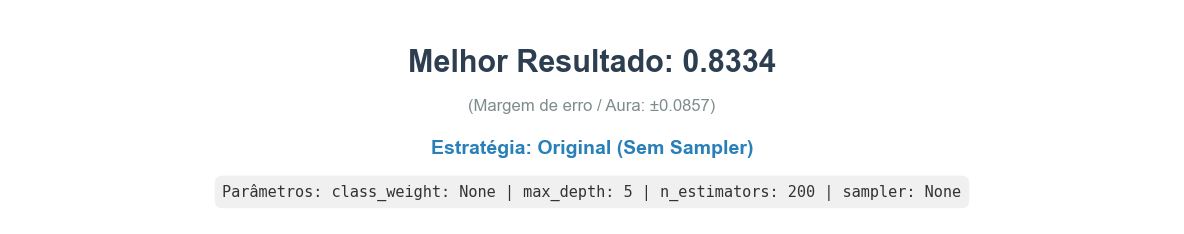

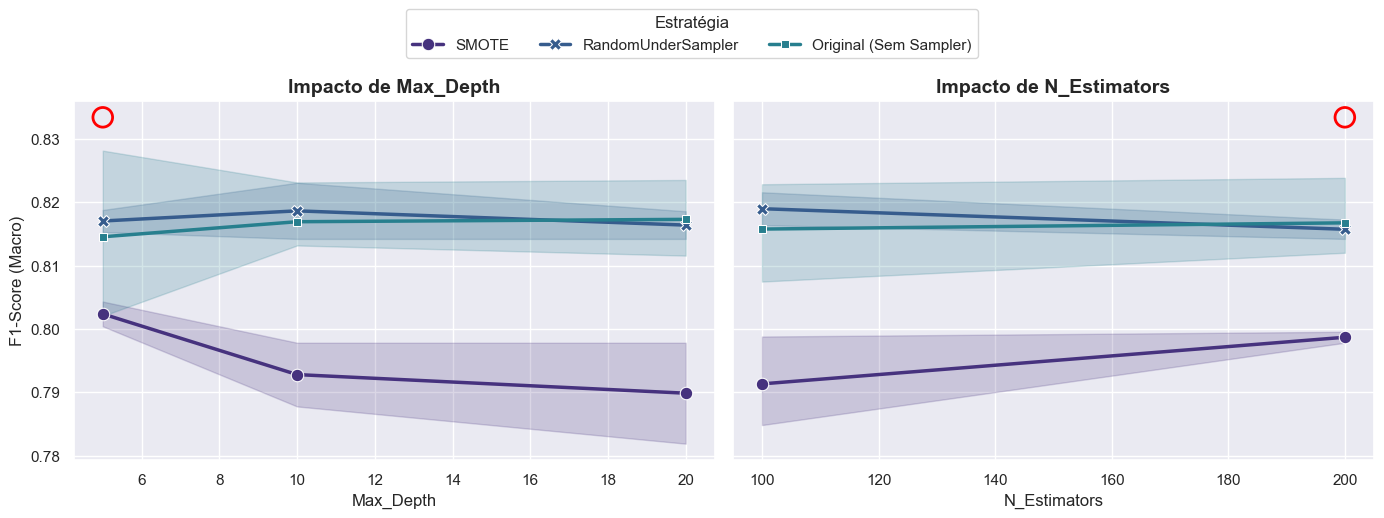

In [7]:
RandomForestClassifier_grid = train_RandomForestClassifier_grid(X_train=X_train, Y_train=Y_train)

plot_grid_performance(RandomForestClassifier_grid)

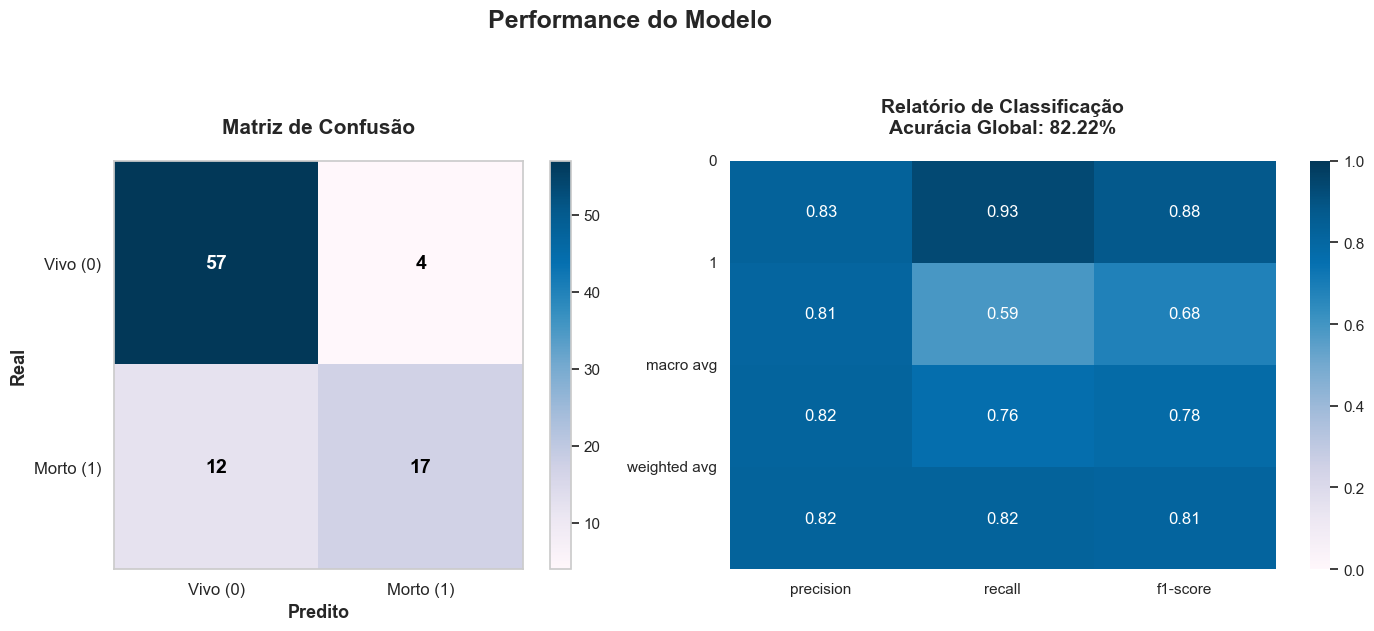

In [8]:
best_model = RandomForestClassifier_grid.best_estimator_
Y_pred = best_model.predict(X_test)

plot_model_performance(y_true=Y_test, y_pred=Y_pred, labels=labels)


## Regressão Logística 

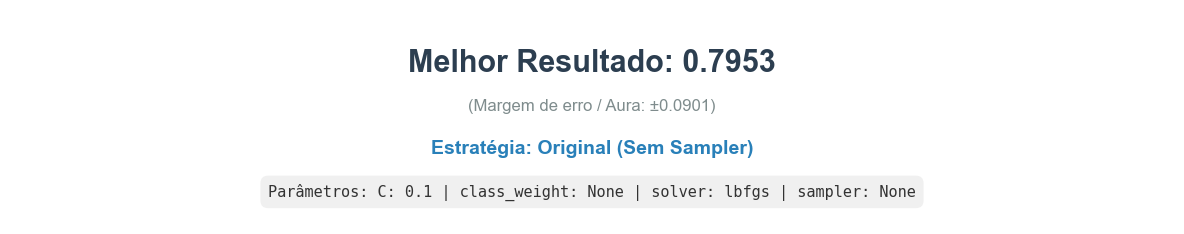

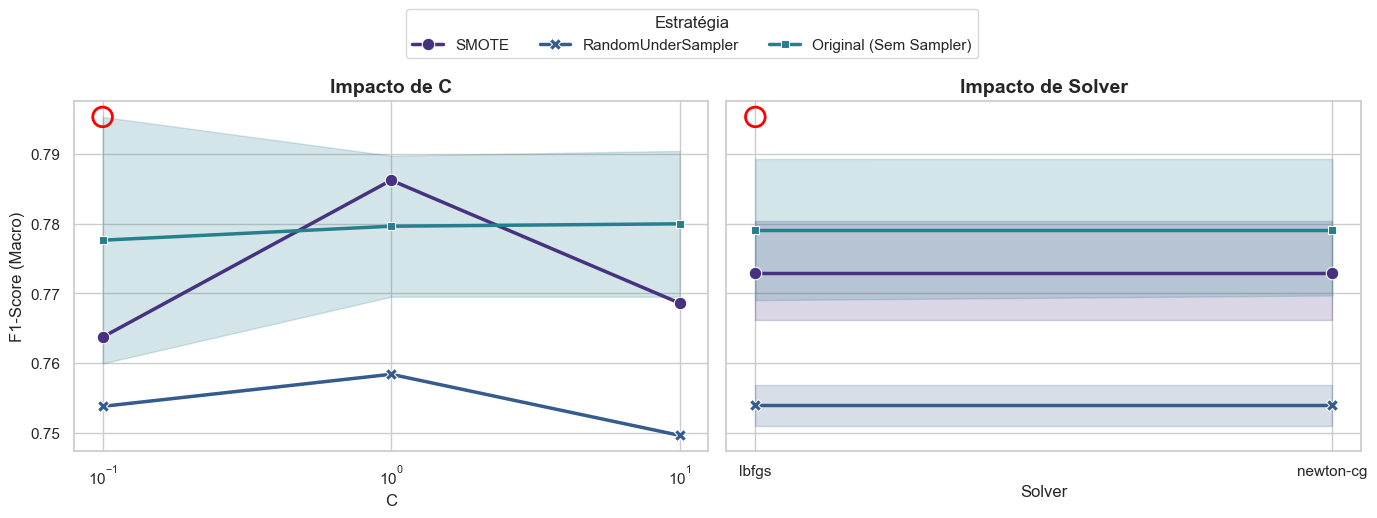

In [9]:
LogisticRegression_grid = train_LogisticRegression_grid(X_train, Y_train)

plot_grid_performance(LogisticRegression_grid)

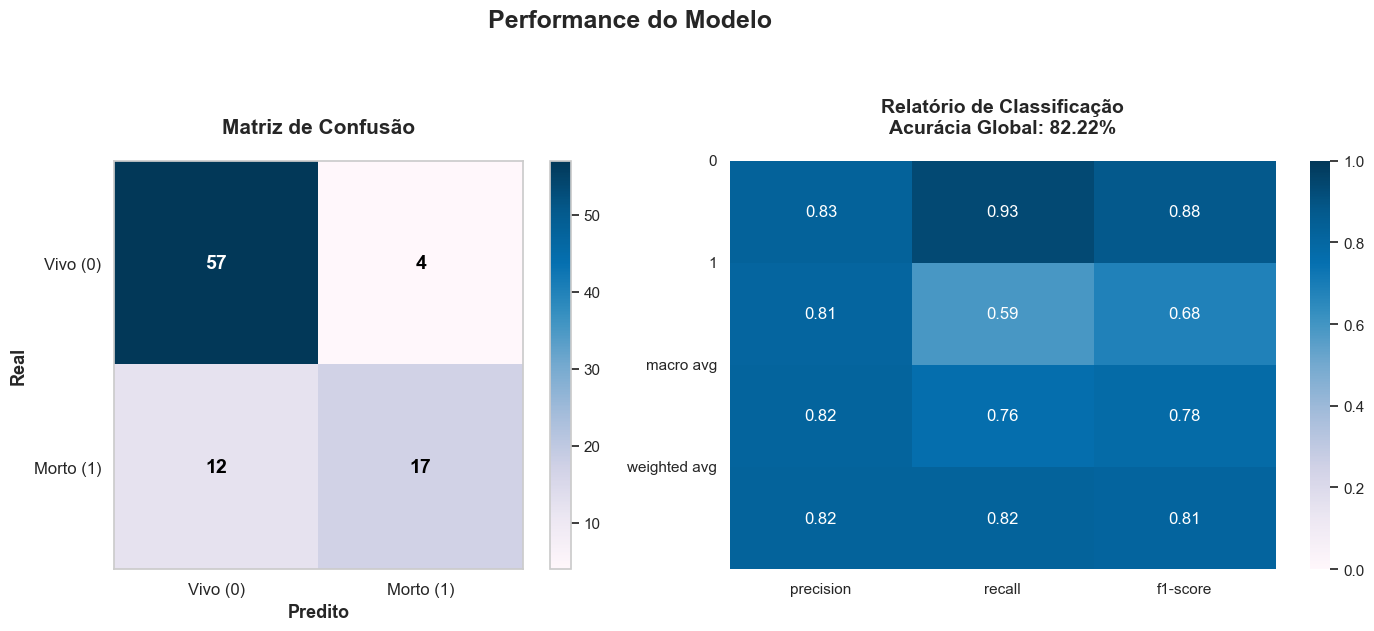

In [10]:
best_model = LogisticRegression_grid.best_estimator_
Y_pred = best_model.predict(X_test)

plot_model_performance(y_true=Y_test, y_pred=Y_pred, labels=labels)

## SVC

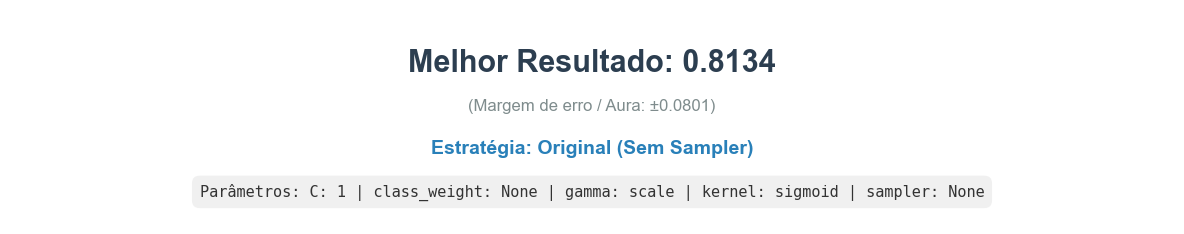

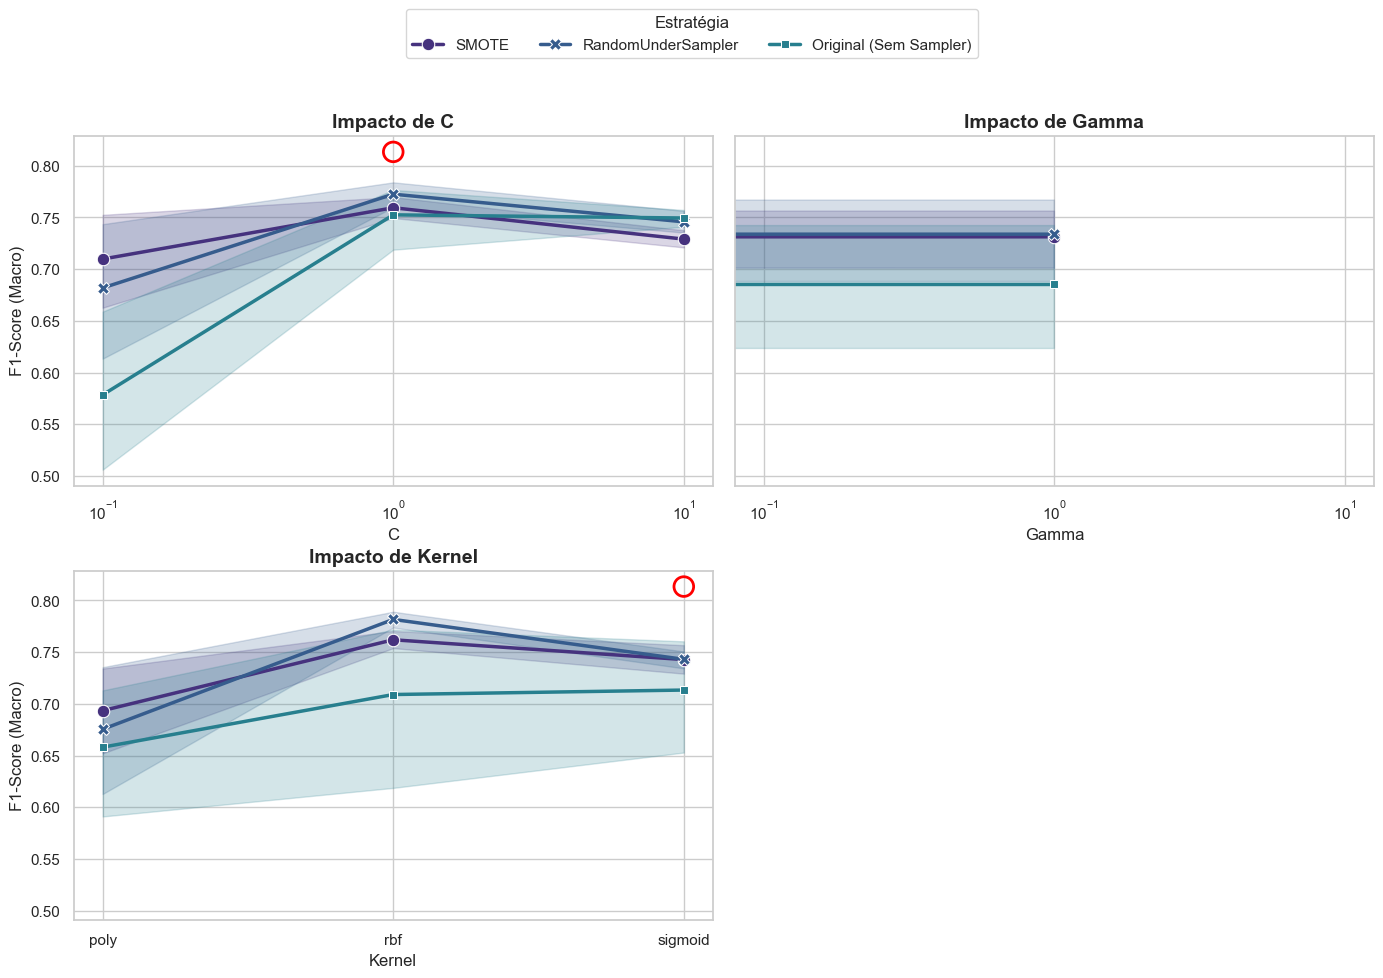

In [11]:
SVC_grid = train_SVC_grid(X_train, Y_train)

plot_grid_performance(SVC_grid)

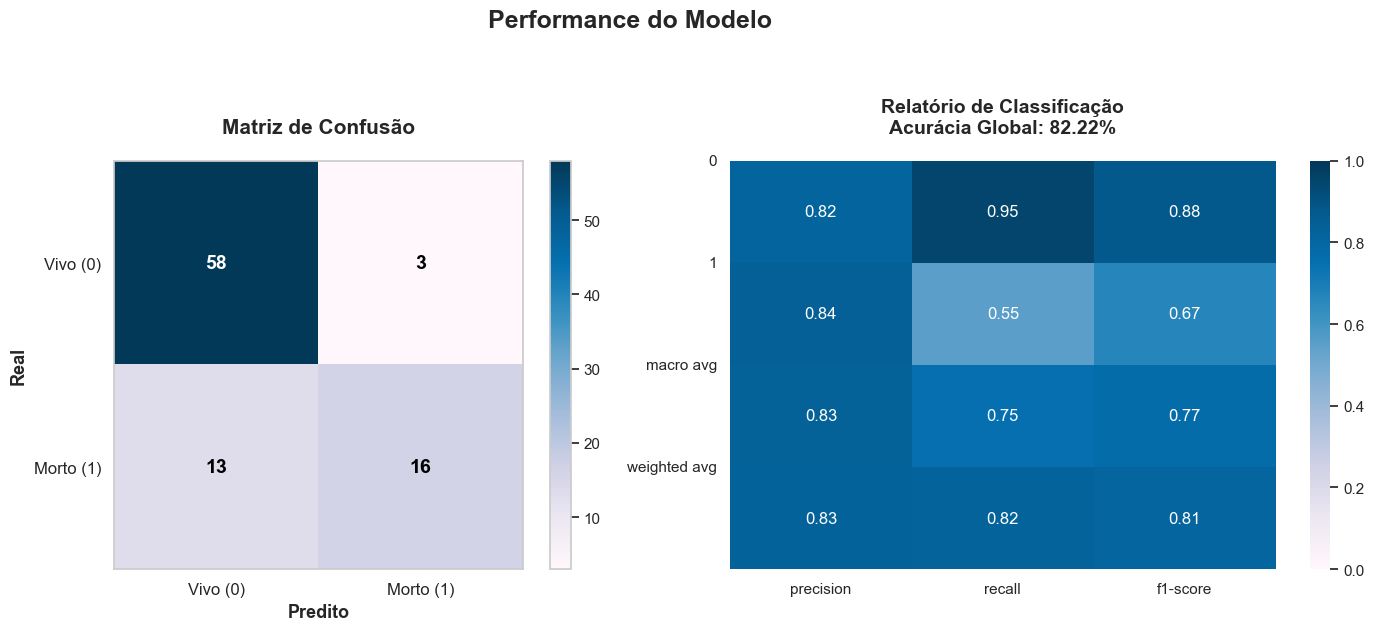

In [12]:
best_model = SVC_grid.best_estimator_
Y_pred = best_model.predict(X_test)

plot_model_performance(y_true=Y_test, y_pred=Y_pred, labels=labels)

## GradientBoostingClassifier

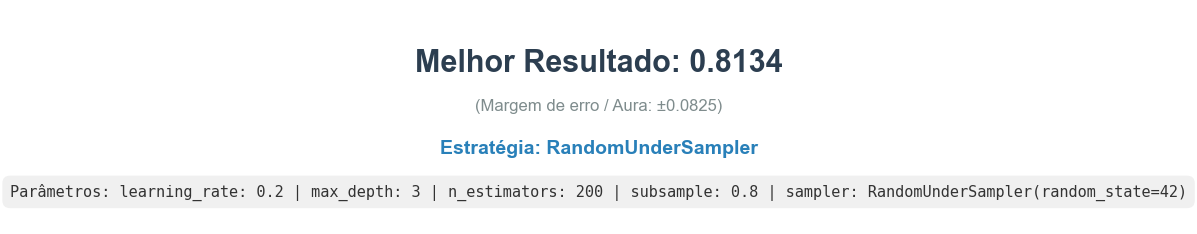

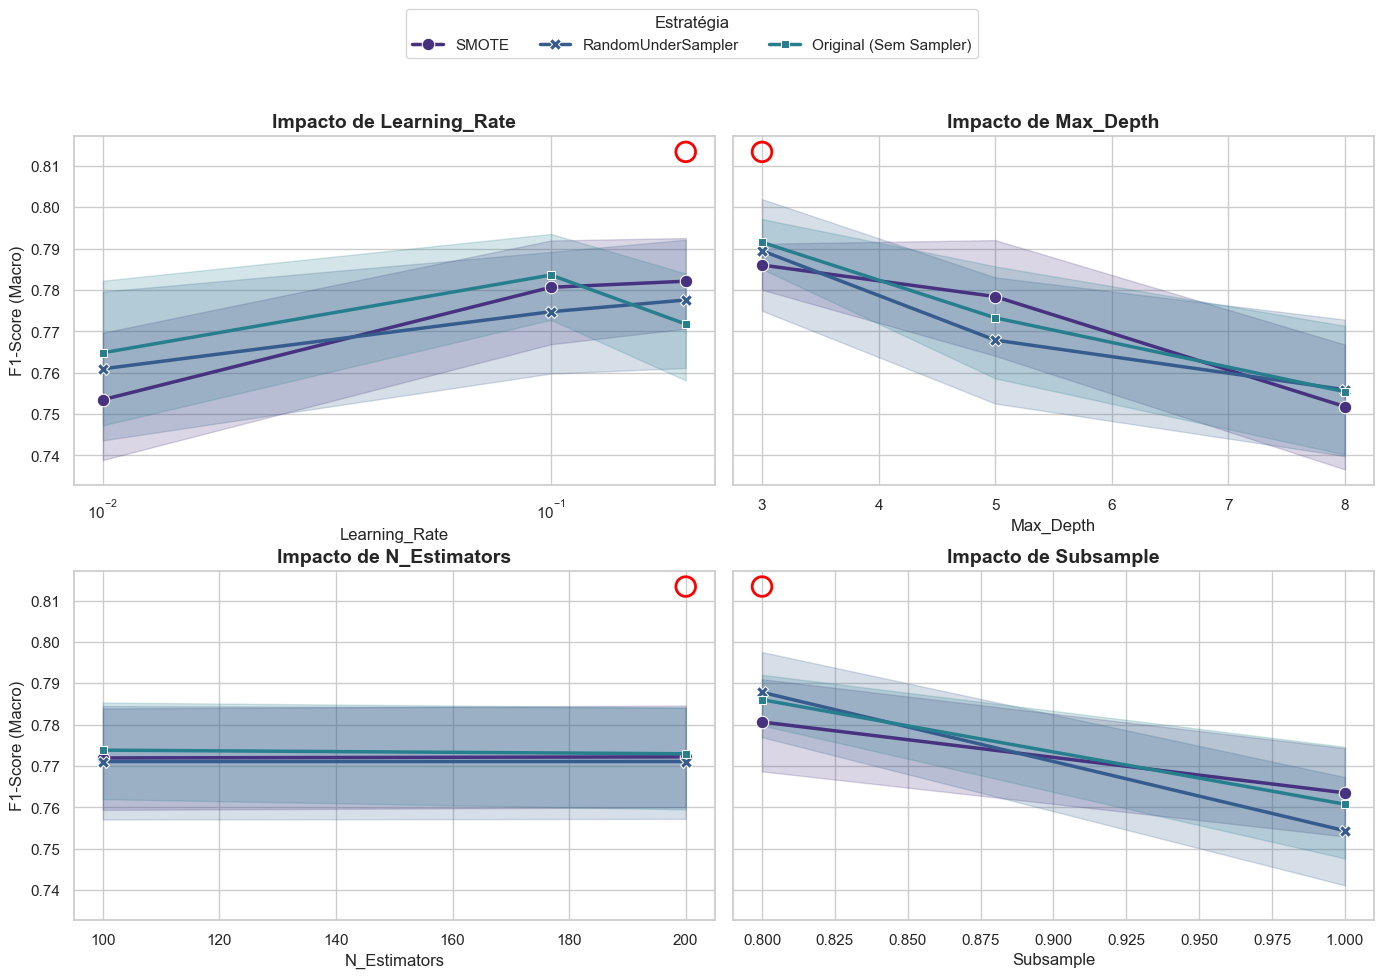

In [13]:
GradientBoostingClassifier_grid = train_GradientBoostingClassifier_grid(X_train, Y_train)

plot_grid_performance(GradientBoostingClassifier_grid)

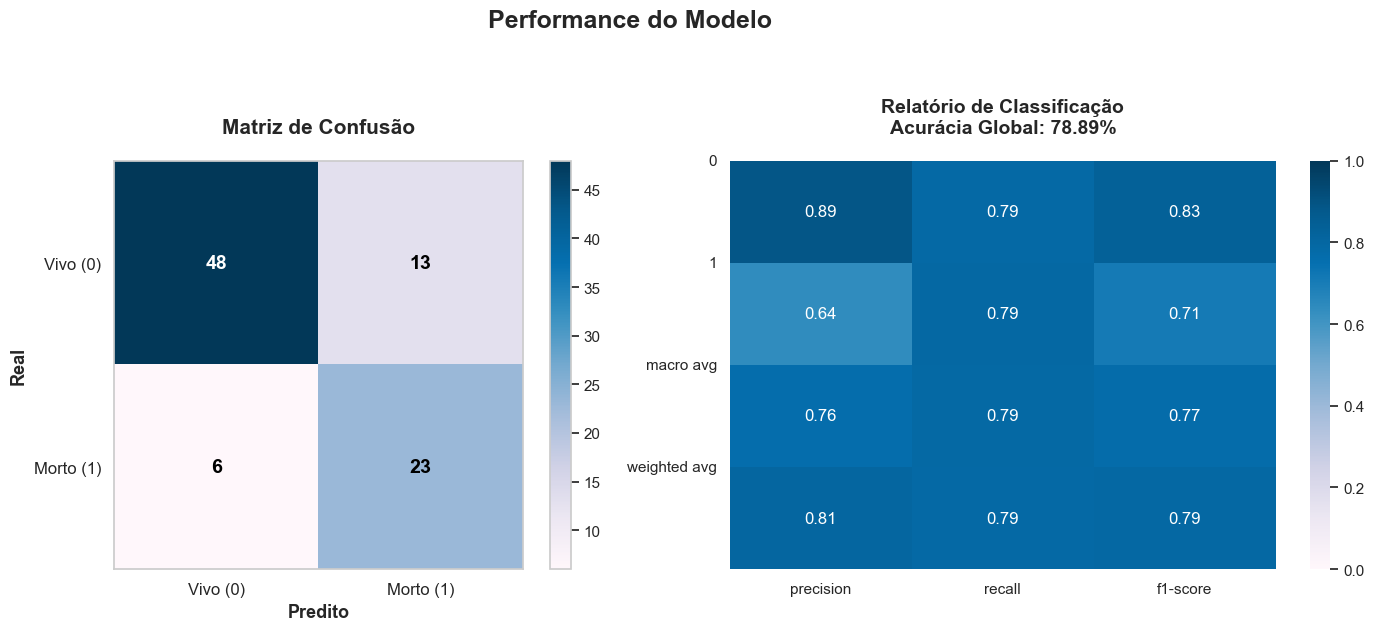

In [14]:
best_model = GradientBoostingClassifier_grid.best_estimator_
Y_pred = best_model.predict(X_test)

plot_model_performance(y_true=Y_test, y_pred=Y_pred, labels=labels)

## Árvore de Desisão 

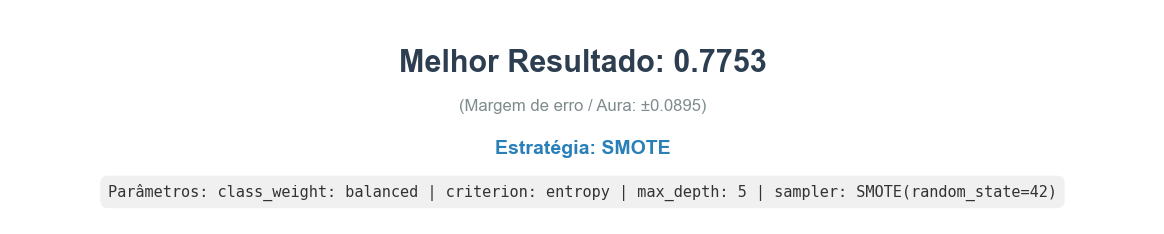

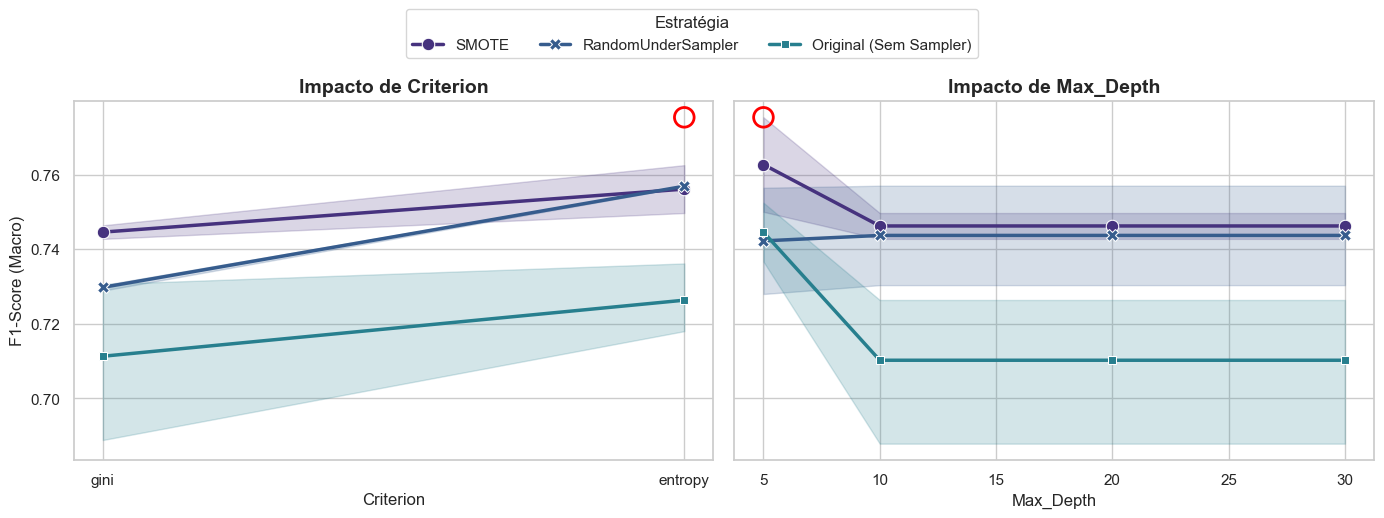

In [15]:
DecisionTreeClassifier_grid = train_DecisionTreeClassifier_grid(X_train, Y_train)

plot_grid_performance(DecisionTreeClassifier_grid)

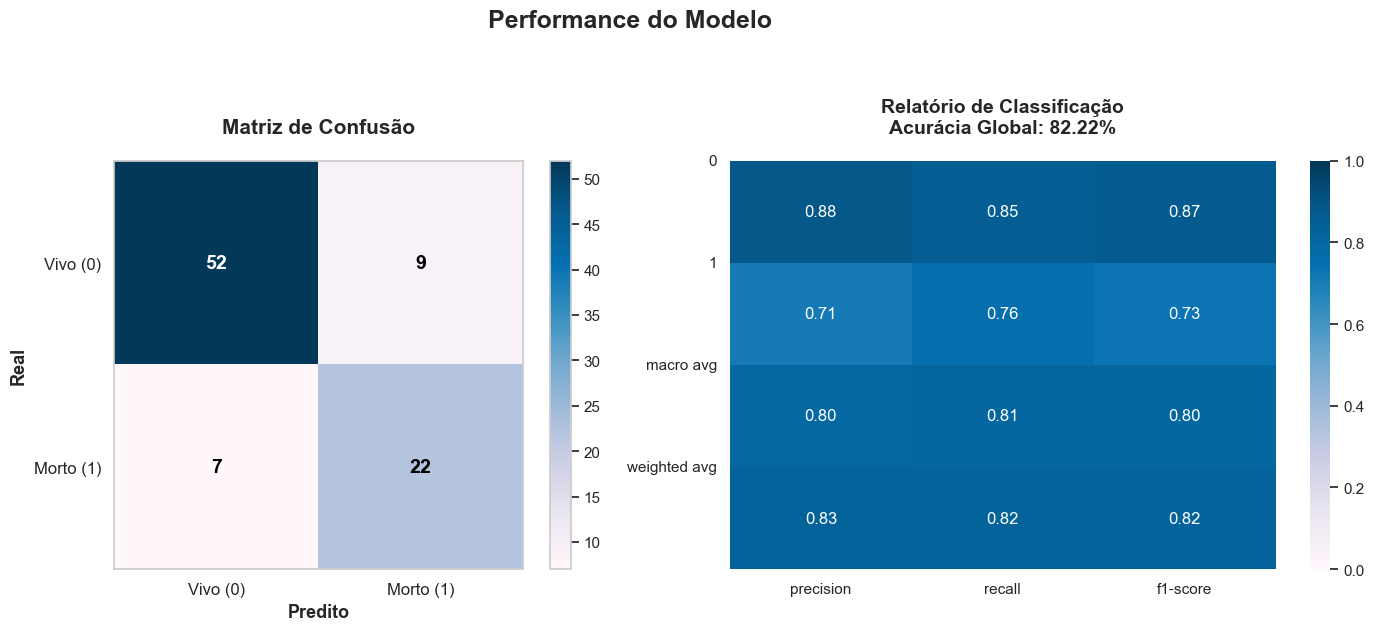

In [16]:
best_model_all = DecisionTreeClassifier_grid.best_estimator_
Y_pred = best_model_all.predict(X_test)

plot_model_performance(y_true=Y_test, y_pred=Y_pred, labels=labels)

## Redes Neurais

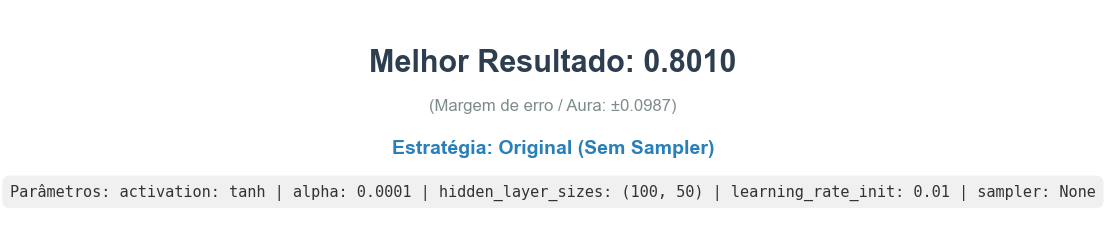

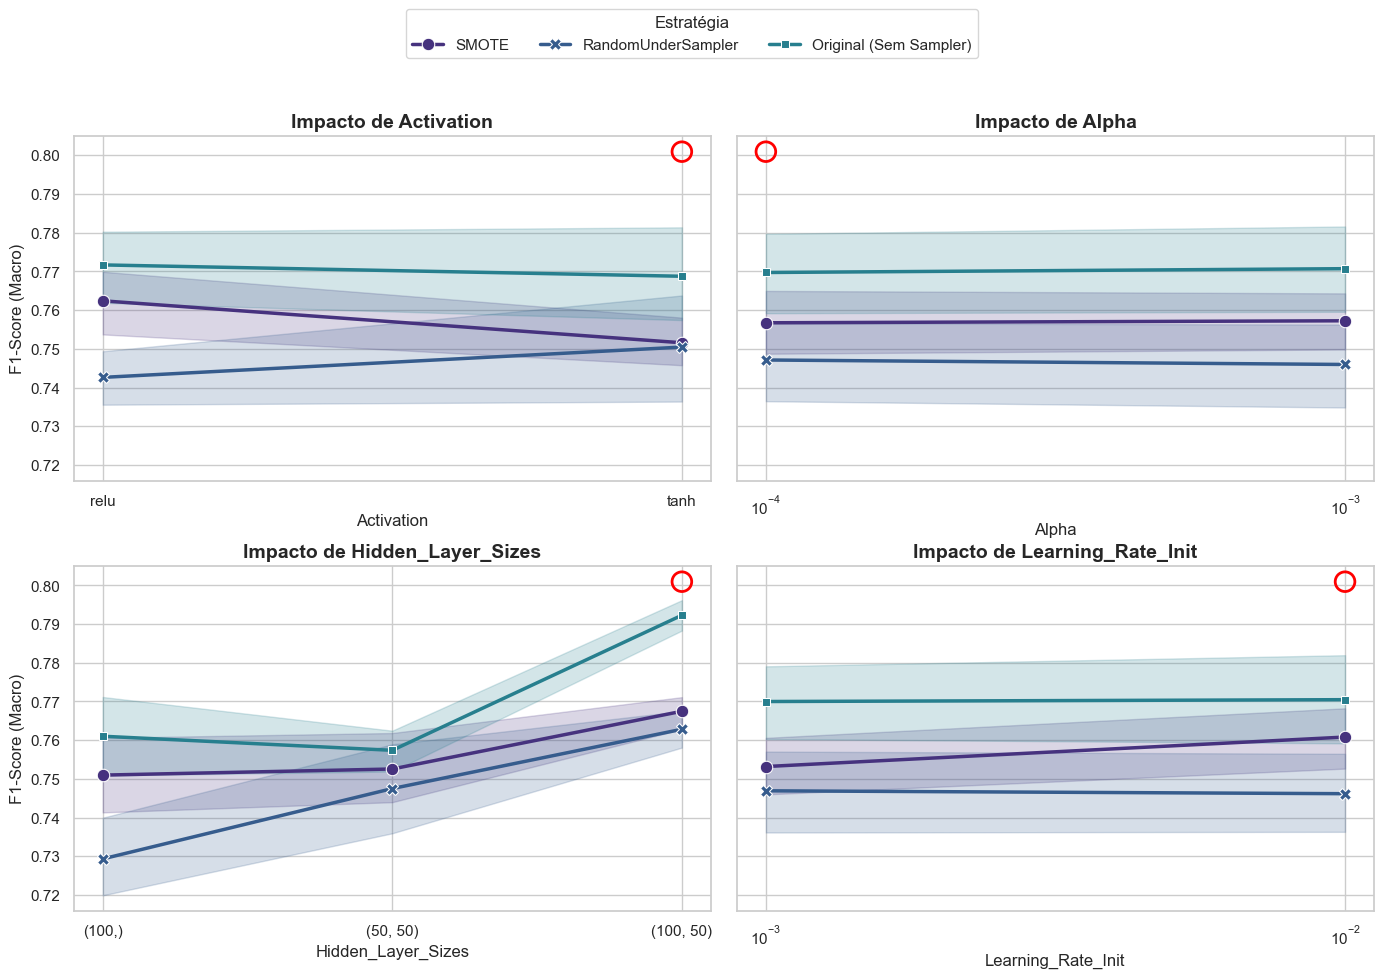

In [17]:
MLPClassifier_grid = train_MLPClassifier_grid(X_train, Y_train)

plot_grid_performance(MLPClassifier_grid)

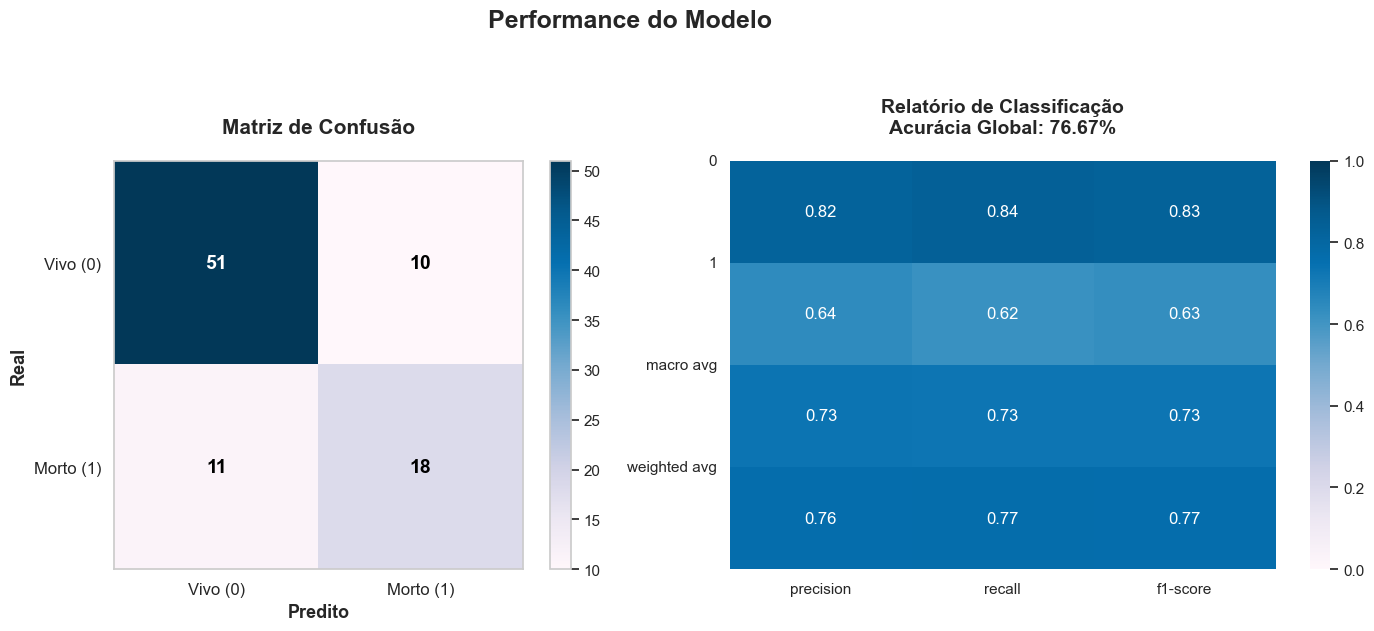

In [18]:
best_model = MLPClassifier_grid.best_estimator_
Y_pred = best_model.predict(X_test)

plot_model_performance(y_true=Y_test, y_pred=Y_pred, labels=labels)

## Qual o melhor Modelo?

Após a avaliação comparativa das abordagens testadas, o modelo selecionado como o mais robusto para a solução do problema foi a **Árvore de Decisão (Decision Tree)**, otimizada e integrada a um pipeline de balanceamento de classes (SMOTE).

A seleção deste modelo baseou-se em uma análise crítica das métricas de desempenho, priorizando a capacidade de detecção da classe minoritária (Classe 1: Óbito) sem sacrificar a precisão global. Abaixo, detalha-se a justificativa técnica frente aos demais algoritmos avaliados:

1. Embora modelos como Random Forest, SVC e Logistic Regression tenham alcançado uma acurácia global competitiva (82%), eles falharam gravemente na métrica mais importante para este domínio médico: o Recall (Revocação) da classe positiva.

- Esses modelos apresentaram um Recall entre 0.55 e 0.59 para a classe 1. Isso significa que eles falharam em identificar aproximadamente 40-45% dos pacientes que realmente vieram a óbito (Falsos Negativos), tornando-os clinicamente inseguros.

2. Ao compararmos a Decision Tree com o Gradient Boosting Classifier (que obteve o maior Recall de 0.79), a Árvore de Decisão mostrou-se superior no equilíbrio geral:

O Gradient Boosting teve um Recall alto, mas sua Precisão caiu para 0.64, indicando um alto número de Falsos Positivos (alarmes falsos).

A Decision Tree alcançou um Recall robusto de 0.76 (detectando a grande maioria dos óbitos) mantendo uma Precisão superior de 0.71.

A Árvore de Decisão apresentou o maior F1-Score para a classe de interesse (0.73) dentre todos os modelos testados. Este resultado comprova que este foi o algoritmo que melhor conseguiu balancear a sensibilidade necessária para não negligenciar pacientes graves (minimizar Falsos Negativos) com a especificidade necessária para evitar diagnósticos alarmistas incorretos (Falsos Positivos).

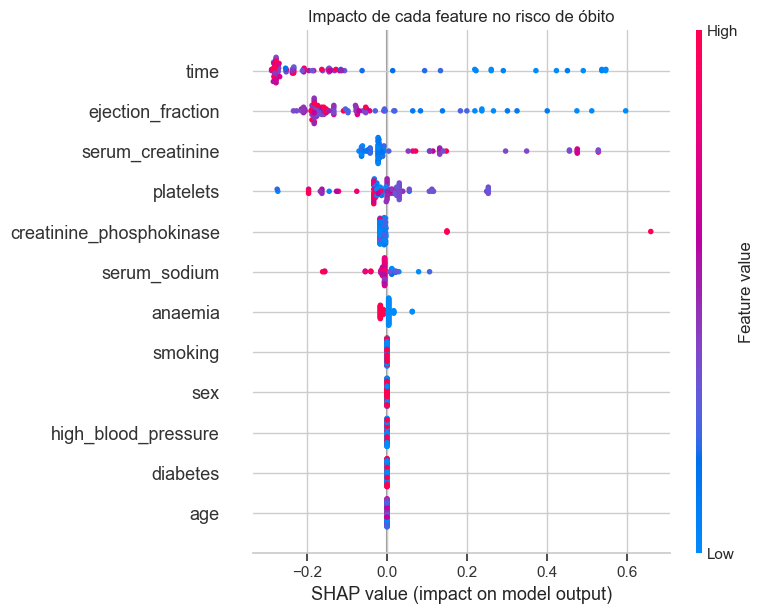

In [19]:
explainer = shap.TreeExplainer(best_model_all[-1])
shap_values = explainer.shap_values(X_test)

plt.title("Impacto de cada feature no risco de óbito")
shap.summary_plot(shap_values[:, :, 1], X_test)